<a href="https://colab.research.google.com/github/RenatoMaximiano/Trabalho_ADP2/blob/main/Balanceado_Pipline_Red_Wine_Quality.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#***Projeto final  Modelagem Preditiva e Descritiva I***

***Alunos:*** Bernardo Morales, Renato Maximiano.

***Banco de Dados:*** [Red-Wine-Quality](https://www.openml.org/search?type=data&status=active&qualities.NumberOfInstances=between_1000_10000&sort=runs&order=asc&id=43695)

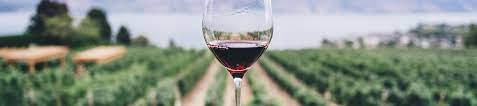

#***A atividade***

Selecionar um banco de dados do OpenML [openml](https://www.openml.org/)
     -- o banco de dados de classificação deve ter: > 3 classes, >10 atributos e >1000 instâncias
     -- cada dupla deve informar qual banco de dados usará com antecedência
-- 10-fold cross-validation
-- avaliar máquinas de aprendizagem: kNN, DT, MLP, NB, SVM, … 
-- métricas (area under the ROC curve, f1-score, accuracy, matriz de confusão média)
-- para ajustar os parâmetros das máquinas de aprendizagem usar grid-search ou escolher os parâmetros e justificar

O relatório final deve conter pelo menos as seguintes informações:
  1. Introdução
  2. Algoritmos de Aprendizagem de Máquina
  3. Experimentos
  3.1. Banco de dados
  3.2. Métricas
  3.3. Resultados 
  4. Conclusões
  Referências


#***Introdução***

Para este trabalho vamos utilizar o banco de dados Red-Wine-Quality, o conjunto de dados está relacionado com variantes tinto e branco do vinho português "Vinho Verde". Por questões de privacidade e logística, apenas variáveis físico-químicas (entradas) e sensoriais (saídas) estão disponíveis (por exemplo, não há dados sobre tipos de uva, marca de vinho, preço de venda do vinho etc.). Esses conjuntos de dados podem ser vistos como tarefas de classificação ou regressão. As classes são ordenadas e não equilibradas (por exemplo, há muito mais vinhos normais do que excelentes ou pobres).
Variáveis de entrada (com base em testes físico-químicos): 1 - acidez fixa 2 - acidez volátil 3 - ácido cítrico 4 - açúcar residual 5 - cloretos 6 - dióxido de enxofre livre 7 - dióxido de enxofre total 8 - densidade 9 - pH 10 - sulfatos 11 – álcool. Variável de saída (baseada em dados sensoriais): 12 - qualidade (pontuação entre 0 e 10).
Para facilitar as análises definimos 3 classes com base nas pontuações dos vinhos. De 0 até 5 (Ruim), igual a 6 (Regular), de 7 até 10 (Bom).  Para este trabalho utilizamos o Optuna como otimizador de hiper parâmetros. Também aplicamos um 10-fold cross-validation dentro de cada iteração, utilizando a melhor média de acurácia para escolher os melhores hiper parâmetros.


#***Fluxograma***
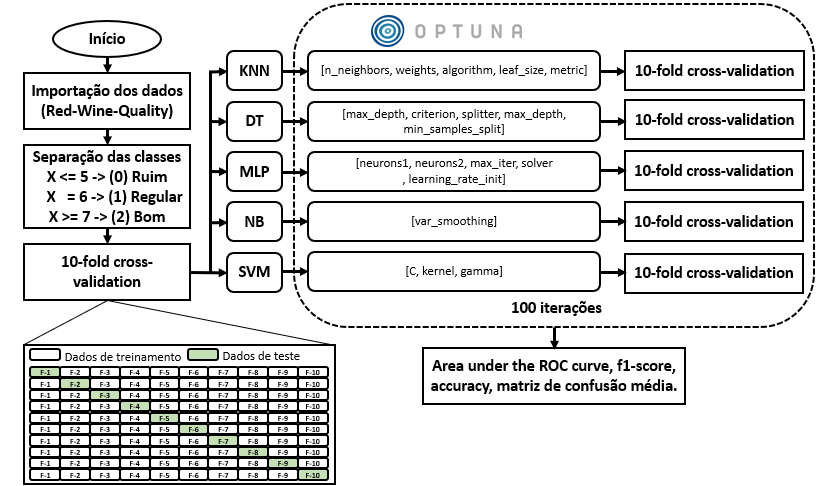

#***Bibliotecas utilizadas no projeto***

In [ ]:
pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 348 kB 4.1 MB/s 
     |████████████████████████████████| 209 kB 48.6 MB/s 
     |████████████████████████████████| 81 kB 7.2 MB/s 
     |████████████████████████████████| 78 kB 6.3 MB/s 
     |████████████████████████████████| 49 kB 5.6 MB/s 
     |████████████████████████████████| 112 kB 49.8 MB/s 
     |████████████████████████████████| 147 kB 35.1 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=47de9fa37e9ba2964473034c7c41b5f6a1036338ac0c61d997d0172c1410b8d9
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
#Bibliotecas de manipualção e visualização de dados
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
import seaborn as sns
from scipy.io.arff import loadarff 

#Classes do modelo de aprendizado
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB, ComplementNB
from sklearn.neural_network import MLPClassifier
import tensorflow as tf
from sklearn.svm import SVC

#Funções de avaliação dos modelos
from sklearn.metrics import classification_report, mean_squared_error, r2_score, accuracy_score, f1_score, plot_roc_curve, recall_score
from sklearn.model_selection import train_test_split
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from keras.utils.np_utils import to_categorical
from sklearn.pipeline import Pipeline
import warnings
from sklearn.metrics import roc_curve, auc
from itertools import cycle
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

import optuna
from optuna.samplers import TPESampler
import random as python_random
optuna.logging.set_verbosity(optuna.logging.WARNING)
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler 
from imblearn.under_sampling import NearMiss
from imblearn.under_sampling import EditedNearestNeighbours 
Sampler_list = [SMOTE(random_state = 9),NearMiss(),"SMOTENearMiss"]


In [ ]:
def reset_seeds():
   np.random.seed(4) 
   python_random.seed(9498)
   tf.random.set_seed(9)

reset_seeds() 

#***Banco de Dados***

Aqui é feito a importação dos dados, a separação das classes e as analises iniciais. 

In [ ]:
#Importação dos dados
raw_data = loadarff('/content/drive/MyDrive/Trabalho_APD/Red_wine')
df_data = pd.DataFrame(raw_data[0])

#Separação das classes.
df_data.loc[df_data["quality"] == 3, "quality"] = 0
df_data.loc[df_data["quality"] == 4, "quality"] = 0
df_data.loc[df_data["quality"] == 5, "quality"] = 0
df_data.loc[df_data["quality"] == 6, "quality"] = 1
df_data.loc[df_data["quality"] == 7, "quality"] = 2
df_data.loc[df_data["quality"] == 8, "quality"] = 2

#Analises iniciais
#df_data = df_data.apply(lambda x: x.str.decode('utf8'))
print("Quantas classes existem nesse dataset?\n%d" %(len(df_data["quality"].unique())))
print("\nQuantas instâncias existem no dataset?\n%d" %(len(df_data)))
print("\nQuantas features existem no dataset?\n%d" %(df_data.shape[1]))
print("\nQue features são essas?\n%s" %(str([k for k in df_data.keys()])))
print("\nQual o numero de instâncias por classe?")
print(df_data["quality"].value_counts())
dataset=df_data
df_data.head()

Quantas classes existem nesse dataset?
3

Quantas instâncias existem no dataset?
1599

Quantas features existem no dataset?
12

Que features são essas?
['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar', 'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']

Qual o numero de instâncias por classe?
0.0    744
1.0    638
2.0    217
Name: quality, dtype: int64


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0.0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0.0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0.0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,1.0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0.0


#***Visualização de espaço de parâmetros***

Confrontando feature por feature.

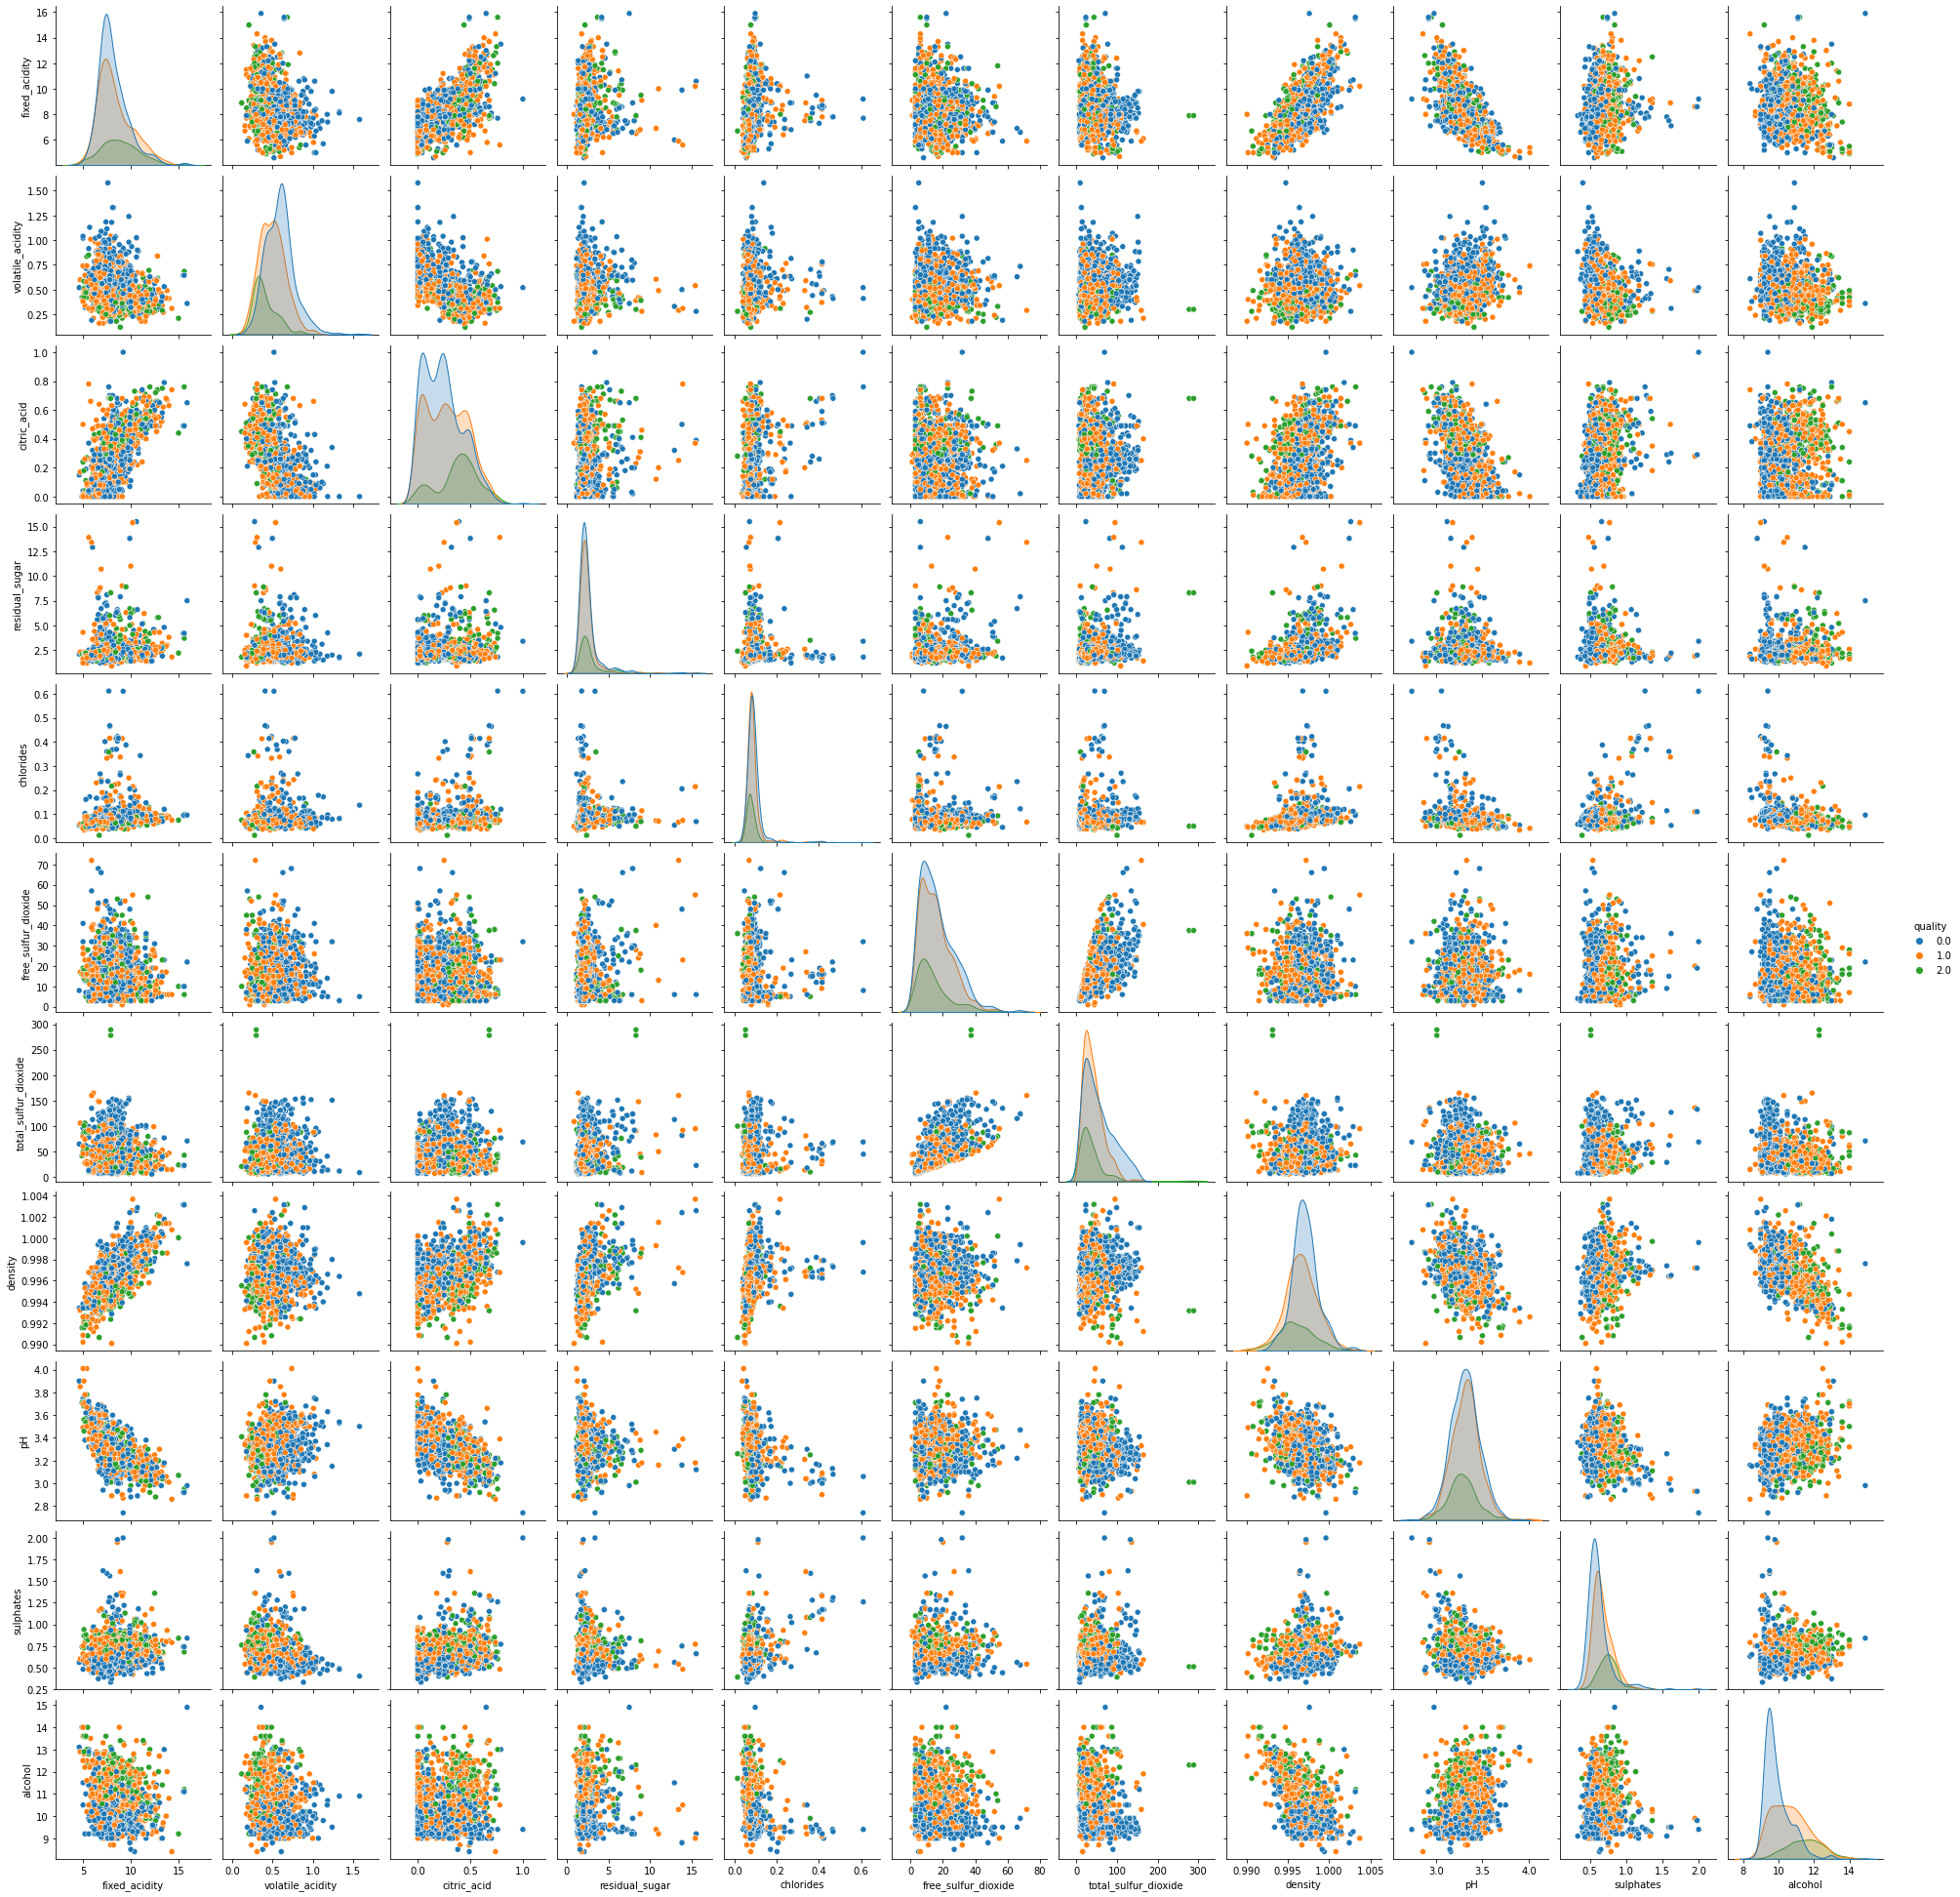

In [ ]:
sns.pairplot(data=df_data, vars=('fixed_acidity',	'volatile_acidity',	'citric_acid',	'residual_sugar',
                               'chlorides',	'free_sulfur_dioxide',	'total_sulfur_dioxide',	'density',	'pH',	'sulphates',	'alcohol'), hue='quality', palette=sns.color_palette()[:3])

#***Separando o Dataset em 10-Fold*** 

Obtendo os índices de forma misturada e aleatória, para o conjunto de treinamento e teste. Onde sempre teremos 9 para treinamento  vs 1 para teste. 

In [ ]:
#Aqui os índices são obtidos, guardados em suas respectivas listas de treinamento e teste, para serem utilizados posteriormente.
dataset=df_data
Train_index = []
Test_index = []
kf = StratifiedKFold(n_splits=10, random_state=9, shuffle=True)

for train_index, test_index in kf.split(dataset.iloc[:,[0,1,2,3,4,5,6,7,8,9,10]],dataset.iloc[:,[11]]):
   Train_index.append(train_index)
   Test_index.append(test_index)

In [ ]:
#Dividindo os dados de entrada dos dados alvos de interesse. 
X = dataset.iloc[:,[0,1,2,3,4,5,6,7,8,9,10]]
y = dataset.iloc[:,[11]]
def Train_test_Kfold(n):
  #Separando o conjunto de dados em treinamento e teste
  global Xtrain, ytrain, Xtest, ytest
  Xtrain, ytrain, Xtest, ytest = X.iloc[Train_index[n]], y.iloc[Train_index[n]], X.iloc[Test_index[n]], y.iloc[Test_index[n]]

#***KNN (K-Nearest Neighbors)***

**********************0**********************
[30, 'uniform', 'brute', 33, 'manhattan'] -> accuracy:0.60625 -> F1-Macro:0.5861409796893667recall score-macro:0.6551587301587302
**********************1**********************
[28, 'uniform', 'ball_tree', 22, 'minkowski'] -> accuracy:0.60625 -> F1-Macro:0.5729079928408036recall score-macro:0.6239285714285714
**********************2**********************
[24, 'distance', 'ball_tree', 47, 'euclidean'] -> accuracy:0.63125 -> F1-Macro:0.6218490211853043recall score-macro:0.6875805675805675
**********************3**********************
[12, 'uniform', 'auto', 46, 'manhattan'] -> accuracy:0.63125 -> F1-Macro:0.60716011042098recall score-macro:0.6678595478595479
**********************4**********************
[30, 'uniform', 'brute', 33, 'manhattan'] -> accuracy:0.6125 -> F1-Macro:0.5915112764427833recall score-macro:0.6428516584766585
**********************5**********************
[30, 'uniform', 'kd_tree', 20, 'minkowski'] -> accuracy:0.5375 -> F1-

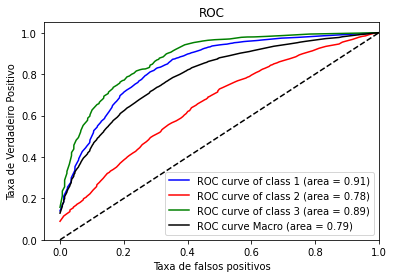

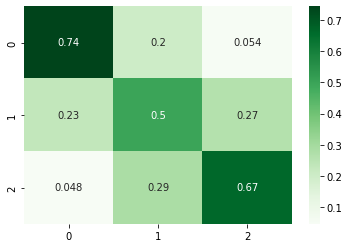

**********************0**********************
[20, 'uniform', 'brute', 36, 'manhattan'] -> accuracy:0.59375 -> F1-Macro:0.5452766728840348recall score-macro:0.5769345238095238
**********************1**********************
[27, 'uniform', 'kd_tree', 42, 'manhattan'] -> accuracy:0.54375 -> F1-Macro:0.5020291278023238recall score-macro:0.5703174603174603
**********************2**********************
[29, 'uniform', 'kd_tree', 23, 'minkowski'] -> accuracy:0.54375 -> F1-Macro:0.49635346044606643recall score-macro:0.5591245791245791
**********************3**********************
[27, 'uniform', 'kd_tree', 20, 'manhattan'] -> accuracy:0.625 -> F1-Macro:0.5987239414514313recall score-macro:0.6377681577681578
**********************4**********************
[24, 'uniform', 'brute', 34, 'manhattan'] -> accuracy:0.60625 -> F1-Macro:0.5775770933003638recall score-macro:0.6042946355446355
**********************5**********************
[10, 'uniform', 'auto', 43, 'manhattan'] -> accuracy:0.59375 -> F1-Ma

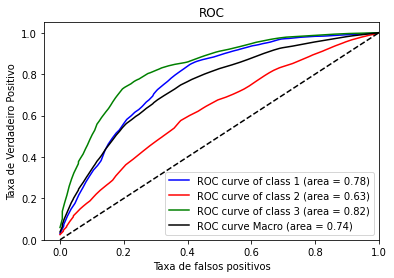

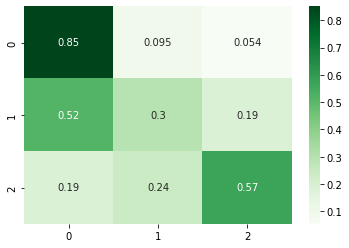

**********************0**********************
[22, 'uniform', 'brute', 23, 'minkowski'] -> accuracy:0.58125 -> F1-Macro:0.5513923784737852recall score-macro:0.6023313492063492
**********************1**********************
[30, 'uniform', 'brute', 33, 'manhattan'] -> accuracy:0.55625 -> F1-Macro:0.5085920356741557recall score-macro:0.5693055555555556
**********************2**********************
[23, 'uniform', 'brute', 23, 'euclidean'] -> accuracy:0.54375 -> F1-Macro:0.527374213836478recall score-macro:0.5946320346320347
**********************3**********************
[21, 'uniform', 'ball_tree', 40, 'manhattan'] -> accuracy:0.675 -> F1-Macro:0.638917004048583recall score-macro:0.6964309764309764
**********************4**********************
[12, 'uniform', 'auto', 46, 'manhattan'] -> accuracy:0.6 -> F1-Macro:0.5716887848035389recall score-macro:0.6203803235053235
**********************5**********************
[30, 'uniform', 'brute', 33, 'manhattan'] -> accuracy:0.5625 -> F1-Macro:0.5340

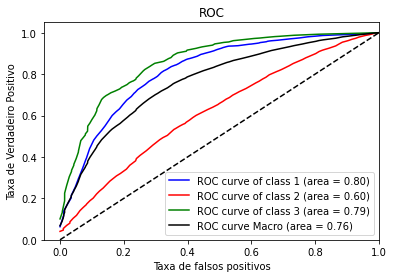

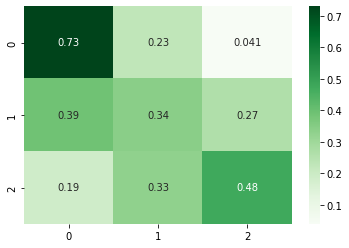

In [ ]:


for Sampler in Sampler_list:
  #Definições de listas para gurdar os valores obtidos em cada iteração 
  #Lista para as pontuações atingidas para cada iteração
  Score_list = []
  #Lista para as pontuações f1-Maxro atingidas para cada iteração
  F1_macro   = []
  #Lista para as pontuações recall_score atingidas para cada iteração
  recall_score_macro = []
  #Lista para as matrizes de confusão atingidas em cada iteração
  cm_list    = []
  #FRP, TPR, ROC_AUC da classe 1
  FRP_0      = []
  TPR_0      = []
  ROC_auc_0  = []
  #FRP, TPR, ROC_AUC da classe 2
  FRP_1      = []
  TPR_1      = []
  ROC_auc_1  = []
  #FRP, TPR, ROC_AUC da classe 3
  FRP_2      = []
  TPR_2      = []
  ROC_auc_2  = []

  #Importancia dos hiperparametros
  h_0 = []
  h_1 = []
  h_2 = []
  h_3 = []
  h_4 = []
  #Iniciando iterações
  for i in range(10):
          #Chamada de cada fold 
          Train_test_Kfold(i)
          from sklearn.preprocessing import MinMaxScaler
          scaler = MinMaxScaler(feature_range=(0, 1)) 
          Xtrain = scaler.fit_transform(Xtrain) 
          Xtest = scaler.transform(Xtest)
          Best = 0.0
          reset_seeds()
          def objective(trial):         
            #Busca de hiperparametros utilizando o Optruna como otimizador
            n_neighbors = trial.suggest_int("n_neighbors", 1, 30)
            weights     = trial.suggest_categorical("weights", ['uniform', 'distance'])
            algorithm   = trial.suggest_categorical("algorithm", ["auto", "ball_tree", "kd_tree", "brute"])
            leaf_size   = trial.suggest_int("leaf_size", 20, 50)
            metric      = trial.suggest_categorical("metric", ['euclidean', 'manhattan', 'minkowski'])

            #Modelo Utilizado -> KNN
            model = KNeighborsClassifier(n_neighbors=n_neighbors, weights=weights, algorithm=algorithm, leaf_size=leaf_size, metric=metric)

            #Variaveis globais
            global Best
            global Model
            global Lista
            global steps

            if Sampler == "SMOTENearMiss":
              oversample = SMOTE(random_state = 9,sampling_strategy={2:480})
              X_res, y_res = oversample.fit_resample(Xtrain, ytrain)
              undersample=NearMiss(sampling_strategy={0:480, 1:480})
              X_res, y_res = undersample.fit_resample(X_res, y_res) 
              steps = [('over', oversample), ('under', undersample), ('m', model)]
            elif Sampler == SMOTE(random_state = 9):
              steps = [('over', Sampler), ('model', model)]
              X_res, y_res = Sampler.fit_resample(Xtrain, ytrain)
            else:
              steps = [('under', Sampler), ('model', model)]
              X_res, y_res = Sampler.fit_resample(Xtrain, ytrain)
            pipeline = Pipeline(steps=steps)
            #Inicializando Kfold-CrossValidation. (Utilizando 9/10 do conjunto de dados)
            kfold = StratifiedKFold(n_splits=10)
            score = cross_val_score(pipeline,Xtrain, ytrain, scoring='accuracy', cv=kfold)
            #Pontuação media Obtida
            Score = score.mean()

            #Salvando a melhor pontuação da iteração e aplicando o fit no modelo
            if Score > Best:
              Best = Score
              model.fit(X_res, y_res)
              Model = model
              Lista = [n_neighbors,weights,algorithm,leaf_size,metric]


            return Score

          #Chamada do Optuna 
          sampler = TPESampler(seed=42) 
          study = optuna.create_study(direction="maximize", sampler=sampler)
          #Definição do numero de iterações -> 100
          study.optimize(objective, n_trials=100)

          Importance = optuna.importance.get_param_importances(study)

          h_0.append(Importance["n_neighbors"])
          h_1.append(Importance["weights"])
          h_2.append(Importance["algorithm"])
          h_3.append(Importance["leaf_size"])
          h_4.append(Importance["metric"])
          

          #Ativação do modelo  para os dados de teste (1/10)
          ypred = Model.predict(Xtest)
          #Obtenção da Acurácia, F1-Score Macro e Matriz de confusão
          Acc = accuracy_score(ytest, ypred)
          F1 = f1_score(ytest, ypred, average='macro')
          rs = recall_score(ytest, ypred, average='macro')
          cm = confusion_matrix(ytest, ypred, normalize="true")
          #Append dos resultados obtidos na iteração
          Score_list.append(Acc)
          F1_macro.append(F1)
          recall_score_macro.append(rs)
          cm_list.append(cm)

          #Obtenção dos dados para curva ROC -> https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
          y_score = Model.predict_proba(Xtest)
          y_test = label_binarize(ytest, classes=[0,1,2])
          fpr = dict()
          tpr = dict()
          roc_auc = dict()
          for j in range(3):
            fpr[j], tpr[j], _ = roc_curve(y_test[:, j], y_score[:, j])
            roc_auc[j] = auc(fpr[j], tpr[j])
          FRP_0.append(fpr[0])
          TPR_0.append(tpr[0])
          ROC_auc_0.append(roc_auc[0])
          FRP_1.append(fpr[1])
          TPR_1.append(tpr[1])
          ROC_auc_1.append(roc_auc[1])
          FRP_2.append(fpr[2])
          TPR_2.append(tpr[2])
          ROC_auc_2.append(roc_auc[2])

          print("**********************"+str(i)+"**********************")
          print(str(Lista)+ " -> accuracy:"+str(Acc)+ " -> F1-Macro:"+ str(F1)+ "recall score-macro:"+ str(rs))

  #Criação da matriz de confusão media
  cm_sum = cm_list[0]
  for i in range(9):
    cm_sum = cm_list[i+1]+cm_sum
  cm_mean= cm_sum/10

  #Criação da curva ROC media
  all_fpr_0 =np.unique(np.concatenate([FRP_0[i] for i in range(10)]))

  mean_tpr_0 = np.zeros_like(all_fpr_0)
  for i in range(10):
      mean_tpr_0 += np.interp(all_fpr_0,FRP_0[i], TPR_0[i])
  mean_tpr_0 /= 10

  all_fpr_1 =np.unique(np.concatenate([FRP_1[i] for i in range(10)]))

  mean_tpr_1 = np.zeros_like(all_fpr_1)
  for i in range(10):
      mean_tpr_1 += np.interp(all_fpr_1,FRP_1[i], TPR_1[i])
  mean_tpr_1 /= 10


  all_fpr_2 =np.unique(np.concatenate([FRP_2[i] for i in range(10)]))

  mean_tpr_2 = np.zeros_like(all_fpr_2)
  for i in range(10):
      mean_tpr_2 += np.interp(all_fpr_2,FRP_2[i], TPR_2[i])
  mean_tpr_2 /= 10

  FRP = [all_fpr_0,all_fpr_1,all_fpr_2]
  TPR = [mean_tpr_0,mean_tpr_1,mean_tpr_2]

  all_fpr =np.unique(np.concatenate([FRP[i] for i in range(3)]))

  mean_tpr = np.zeros_like(all_fpr)
  for i in range(3):
      mean_tpr += np.interp(all_fpr,FRP[i], TPR[i])
  mean_tpr /= 3

  #Pontuações e desvio padrão
  print("Acuracia: %.2f%% (%.2f%%)" % (np.array(Score_list).mean()*100,np.array(Score_list).std()*100))
  print("F1-Score Macro: %.2f%% (%.2f%%)" % (np.array(F1_macro).mean()*100, np.array(F1_macro).std()*100))
  print("recall score macro: %.2f%% (%.2f%%)" % (np.array(recall_score_macro).mean()*100, np.array(recall_score_macro).std()*100))
  print("n_neighbors: %.2f%%, weights: %.2f%%, algorithm: %.2f%%, leaf_size: %.2f%%, metric: %.2f%%" % (np.array(h_0).mean(), np.array(h_1).mean(), np.array(h_2).mean(),np.array(h_3).mean(),np.array(h_4).mean()))
  #Plots Finais
  roc_auc[3] = (auc(all_fpr, mean_tpr))
  colors = cycle(['blue', 'red', 'green'])
  a= [all_fpr_0,all_fpr_1,all_fpr_2, all_fpr]
  b = [mean_tpr_0,mean_tpr_1,mean_tpr_2, mean_tpr]
  for i, color in zip(range(3), colors):
      plt.plot(a[i], b[i], color=color,
              label='ROC curve of class {0} (area = {1:0.2f})'
              ''.format(i+1, roc_auc[i]))

  plt.plot(a[3], b[3], color="black",
              label='ROC curve Macro (area = {1:0.2f})'
              ''.format(1, roc_auc[3]))

  plt.plot([0, 1], [0, 1], 'k--')
  plt.xlim([-0.05, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('Taxa de falsos positivos')
  plt.ylabel('Taxa de Verdadeiro Positivo')
  plt.title('ROC')
  plt.legend(loc="lower right")
  plt.show()
  sns.heatmap(cm, annot=True, cmap="Greens")
  plt.show()

#***DT (Decision tree)***

**********************0**********************
[10, 'entropy', 'random', 5, 2] -> accuracy:0.63125 -> F1-Macro:0.6122968818620992recall score-macro:0.6546626984126984
**********************1**********************
[17, 'entropy', 'best', 5, 1] -> accuracy:0.69375 -> F1-Macro:0.64996114996115recall score-macro:0.6633234126984127
**********************2**********************
[12, 'entropy', 'random', 4, 3] -> accuracy:0.625 -> F1-Macro:0.6140908306746243recall score-macro:0.6346801346801346
**********************3**********************
[10, 'gini', 'best', 2, 3] -> accuracy:0.725 -> F1-Macro:0.7065966641665774recall score-macro:0.71002405002405
**********************4**********************
[11, 'gini', 'random', 2, 1] -> accuracy:0.575 -> F1-Macro:0.5494825617071643recall score-macro:0.5647010647010647
**********************5**********************
[10, 'gini', 'random', 3, 3] -> accuracy:0.58125 -> F1-Macro:0.5427428986861921recall score-macro:0.5500230343980345
**********************6****

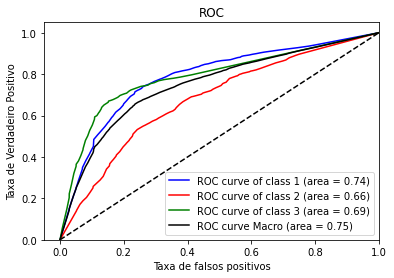

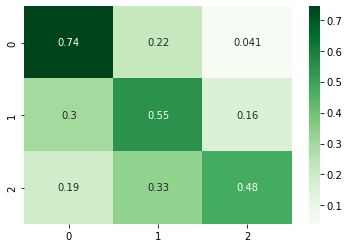

**********************0**********************
[10, 'entropy', 'best', 3, 2] -> accuracy:0.58125 -> F1-Macro:0.5344799782015136recall score-macro:0.5695734126984127
**********************1**********************
[10, 'entropy', 'random', 5, 3] -> accuracy:0.56875 -> F1-Macro:0.5403874717468518recall score-macro:0.5919146825396826
**********************2**********************
[14, 'entropy', 'best', 4, 2] -> accuracy:0.55625 -> F1-Macro:0.5336374951054428recall score-macro:0.5837999037999039
**********************3**********************
[10, 'gini', 'random', 5, 3] -> accuracy:0.51875 -> F1-Macro:0.5170124433542355recall score-macro:0.5399518999519
**********************4**********************
[18, 'entropy', 'best', 4, 3] -> accuracy:0.55625 -> F1-Macro:0.5442266417684535recall score-macro:0.588848791973792
**********************5**********************
[16, 'gini', 'best', 4, 2] -> accuracy:0.6 -> F1-Macro:0.5635189648003379recall score-macro:0.5898469492219492
**********************6***

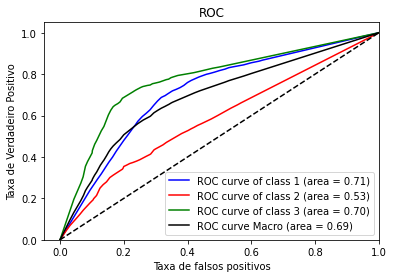

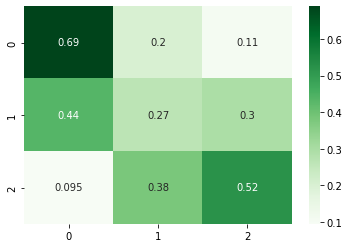

**********************0**********************
[10, 'gini', 'best', 3, 2] -> accuracy:0.61875 -> F1-Macro:0.6026566636322735recall score-macro:0.6244444444444444
**********************1**********************
[13, 'gini', 'random', 2, 3] -> accuracy:0.6 -> F1-Macro:0.5995277189546225recall score-macro:0.6362599206349207
**********************2**********************
[20, 'entropy', 'random', 3, 2] -> accuracy:0.56875 -> F1-Macro:0.519812444751912recall score-macro:0.5270514670514671
**********************3**********************
[17, 'gini', 'best', 3, 2] -> accuracy:0.61875 -> F1-Macro:0.5632936507936508recall score-macro:0.5724675324675325
**********************4**********************
[10, 'entropy', 'random', 5, 2] -> accuracy:0.61875 -> F1-Macro:0.6029414539348315recall score-macro:0.6274697993447993
**********************5**********************
[11, 'entropy', 'best', 3, 2] -> accuracy:0.66875 -> F1-Macro:0.6559559819087951recall score-macro:0.6499539312039312
**********************6*

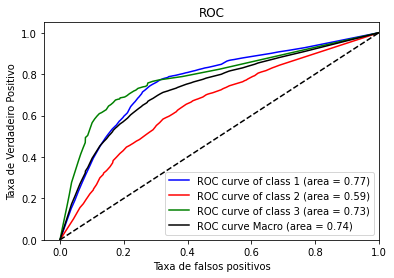

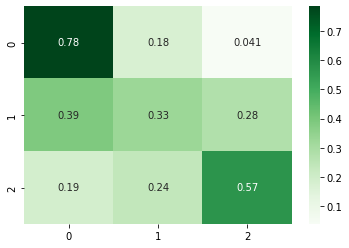

In [ ]:
for Sampler in Sampler_list:
  #Definições de listas para guardar os valores obtidos em cada iteração 
  #Lista para as pontuações atingidas para cada iteração
  Score_list = []
  #Lista para as pontuações f1-Maxro atingidas para cada iteração
  F1_macro   = []
  #Lista para as pontuações recall_score atingidas para cada iteração
  recall_score_macro = []
  #Lista para as matrizes de confusão atingidas em cada iteração
  cm_list    = []
  #FRP, TPR, ROC_AUC da classe 1
  FRP_0      = []
  TPR_0      = []
  ROC_auc_0  = []
  #FRP, TPR, ROC_AUC da classe 2
  FRP_1      = []
  TPR_1      = []
  ROC_auc_1  = []
  #FRP, TPR, ROC_AUC da classe 3
  FRP_2      = []
  TPR_2      = []
  ROC_auc_2  = []

  #Importancia dos hiperparametros
  h_0 = []
  h_1 = []
  h_2 = []
  h_3 = []
  h_4 = []

  #Iniciando iterações
  for i in range(10):
          #Chamada de cada fold 
          Train_test_Kfold(i)
          scaler = MinMaxScaler(feature_range=(0, 1)) 
          Xtrain = scaler.fit_transform(Xtrain) 
          Xtest = scaler.transform(Xtest)
          Best = 0.0
          reset_seeds()
          def objective(trial):         
            #Busca de hiperparametros utilizando o Optruna como otimizador
            max_depth = trial.suggest_int("max_depth", 10,20)
            criterion     = trial.suggest_categorical("criterion", ['gini', 'entropy'])
            splitter   = trial.suggest_categorical("splitter", ["best", "random"])
            min_samples_split   = trial.suggest_int("min_samples_split", 2,5)
            min_samples_leaf   = trial.suggest_int("min_samples_leaf", 1, 3)

            #Modelo Utilizado -> KNN
            model = DecisionTreeClassifier(criterion=criterion, splitter=splitter, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf)

            #Variaveis globais
            global Best
            global Model
            global Lista
            if Sampler == "SMOTENearMiss":
              oversample = SMOTE(random_state = 9,sampling_strategy={2:480})
              X_res, y_res = oversample.fit_resample(Xtrain, ytrain)
              undersample=NearMiss(sampling_strategy={0:480, 1:480})
              X_res, y_res = undersample.fit_resample(X_res, y_res) 
              steps = [('over', oversample), ('under', undersample), ('m', model)]
            elif Sampler == SMOTE(random_state = 9):
              steps = [('over', Sampler), ('model', model)]
              X_res, y_res = Sampler.fit_resample(Xtrain, ytrain)
            else:
              steps = [('under', Sampler), ('model', model)]
              X_res, y_res = Sampler.fit_resample(Xtrain, ytrain)
            pipeline = Pipeline(steps=steps)
            #Inicializando Kfold-CrossValidation. (Utilizando 9/10 do conjunto de dados)
            kfold = StratifiedKFold(n_splits=10)
            score = cross_val_score(pipeline,Xtrain, ytrain, scoring='accuracy', cv=kfold)
            #Pontuação media Obtida
            Score = score.mean()

            #Salvando a melhor pontuação da iteração e aplicando o fit no modelo
            if Score > Best:
              Best = Score
              model.fit(X_res, y_res)
              Model = model
              Lista = [max_depth,criterion,splitter,min_samples_split,min_samples_leaf]


            return Score

          #Chamada do Optuna 
          sampler = TPESampler(seed=42) 
          study = optuna.create_study(direction="maximize", sampler=sampler)
          #Definição do numero de iterações -> 100
          study.optimize(objective, n_trials=100)

          Importance = optuna.importance.get_param_importances(study)

          h_0.append(Importance["max_depth"])
          h_1.append(Importance["criterion"])
          h_2.append(Importance["splitter"])
          h_3.append(Importance["min_samples_split"])
          h_4.append(Importance["min_samples_leaf"])
          

          #Ativação do modelo  para os dados de teste (1/10)
          ypred = Model.predict(Xtest)
          #Obtenção da Acurácia, F1-Score Macro e Matriz de confusão
          Acc = accuracy_score(ytest, ypred)
          F1 = f1_score(ytest, ypred, average='macro')
          rs = recall_score(ytest, ypred, average='macro')
          cm = confusion_matrix(ytest, ypred, normalize="true")
          #Append dos resultados obtidos na iteração
          Score_list.append(Acc)
          F1_macro.append(F1)
          recall_score_macro.append(rs)
          cm_list.append(cm)

          #Obtenção dos dados para curva ROC -> https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
          y_score = Model.predict_proba(Xtest)
          y_test = label_binarize(ytest, classes=[0,1,2])
          fpr = dict()
          tpr = dict()
          roc_auc = dict()
          for j in range(3):
            fpr[j], tpr[j], _ = roc_curve(y_test[:, j], y_score[:, j])
            roc_auc[j] = auc(fpr[j], tpr[j])
          FRP_0.append(fpr[0])
          TPR_0.append(tpr[0])
          ROC_auc_0.append(roc_auc[0])
          FRP_1.append(fpr[1])
          TPR_1.append(tpr[1])
          ROC_auc_1.append(roc_auc[1])
          FRP_2.append(fpr[2])
          TPR_2.append(tpr[2])
          ROC_auc_2.append(roc_auc[2])

          print("**********************"+str(i)+"**********************")
          print(str(Lista)+ " -> accuracy:"+str(Acc)+ " -> F1-Macro:"+ str(F1)+ "recall score-macro:"+ str(rs))

  #Criação da matriz de confusão media
  cm_sum = cm_list[0]
  for i in range(9):
    cm_sum = cm_list[i+1]+cm_sum
  cm_mean= cm_sum/10

  #Criação da curva ROC media
  all_fpr_0 =np.unique(np.concatenate([FRP_0[i] for i in range(10)]))

  mean_tpr_0 = np.zeros_like(all_fpr_0)
  for i in range(10):
      mean_tpr_0 += np.interp(all_fpr_0,FRP_0[i], TPR_0[i])
  mean_tpr_0 /= 10

  all_fpr_1 =np.unique(np.concatenate([FRP_1[i] for i in range(10)]))

  mean_tpr_1 = np.zeros_like(all_fpr_1)
  for i in range(10):
      mean_tpr_1 += np.interp(all_fpr_1,FRP_1[i], TPR_1[i])
  mean_tpr_1 /= 10


  all_fpr_2 =np.unique(np.concatenate([FRP_2[i] for i in range(10)]))

  mean_tpr_2 = np.zeros_like(all_fpr_2)
  for i in range(10):
      mean_tpr_2 += np.interp(all_fpr_2,FRP_2[i], TPR_2[i])
  mean_tpr_2 /= 10

  FRP = [all_fpr_0,all_fpr_1,all_fpr_2]
  TPR = [mean_tpr_0,mean_tpr_1,mean_tpr_2]

  all_fpr =np.unique(np.concatenate([FRP[i] for i in range(3)]))

  mean_tpr = np.zeros_like(all_fpr)
  for i in range(3):
      mean_tpr += np.interp(all_fpr,FRP[i], TPR[i])
  mean_tpr /= 3

  #Pontuações e desvio padrão
  print("Acuracia: %.2f%% (%.2f%%)" % (np.array(Score_list).mean()*100,np.array(Score_list).std()*100))
  print("F1-Score Macro: %.2f%% (%.2f%%)" % (np.array(F1_macro).mean()*100, np.array(F1_macro).std()*100))
  print("recall score macro: %.2f%% (%.2f%%)" % (np.array(recall_score_macro).mean()*100, np.array(recall_score_macro).std()*100))
  print("max_depth: %.2f%%, criterion: %.2f%%, splitter: %.2f%%, min_samples_split: %.2f%%, min_samples_leaf: %.2f%%" % (np.array(h_0).mean(), np.array(h_1).mean(), np.array(h_2).mean(),np.array(h_3).mean(),np.array(h_4).mean()))
  #Plots Finais
  roc_auc[3] = (auc(all_fpr, mean_tpr))
  colors = cycle(['blue', 'red', 'green'])
  a= [all_fpr_0,all_fpr_1,all_fpr_2, all_fpr]
  b = [mean_tpr_0,mean_tpr_1,mean_tpr_2, mean_tpr]
  for i, color in zip(range(3), colors):
      plt.plot(a[i], b[i], color=color,
              label='ROC curve of class {0} (area = {1:0.2f})'
              ''.format(i+1, roc_auc[i]))

  plt.plot(a[3], b[3], color="black",
              label='ROC curve Macro (area = {1:0.2f})'
              ''.format(1, roc_auc[3]))

  plt.plot([0, 1], [0, 1], 'k--')
  plt.xlim([-0.05, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('Taxa de falsos positivos')
  plt.ylabel('Taxa de Verdadeiro Positivo')
  plt.title('ROC')
  plt.legend(loc="lower right")
  plt.show()
  sns.heatmap(cm, annot=True, cmap="Greens")
  plt.show()

#***GNB (Gaussian Naive Bayes)***

**********************0**********************
[3.807947176588889e-09] -> accuracy:0.6125 -> F1-Macro:0.5775781850548206recall score-macro:0.6382738095238095
**********************1**********************
[3.807947176588889e-09] -> accuracy:0.5625 -> F1-Macro:0.5393027097004598recall score-macro:0.6034821428571429
**********************2**********************
[3.807947176588889e-09] -> accuracy:0.525 -> F1-Macro:0.5048165426806204recall score-macro:0.592005772005772
**********************3**********************
[3.807947176588889e-09] -> accuracy:0.59375 -> F1-Macro:0.5742512585578279recall score-macro:0.6468205868205869
**********************4**********************
[3.807947176588889e-09] -> accuracy:0.5125 -> F1-Macro:0.5090381686008131recall score-macro:0.5566134316134316
**********************5**********************
[3.807947176588889e-09] -> accuracy:0.4875 -> F1-Macro:0.4556759121005083recall score-macro:0.5031352375102375
**********************6**********************
[3.8079471765

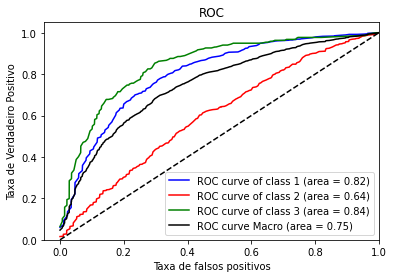

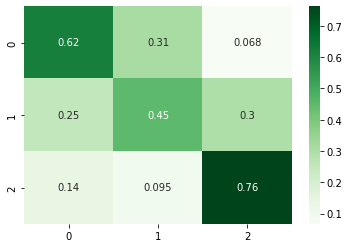

**********************0**********************
[3.807947176588889e-09] -> accuracy:0.5 -> F1-Macro:0.45942665129139854recall score-macro:0.4881746031746032
**********************1**********************
[3.807947176588889e-09] -> accuracy:0.45625 -> F1-Macro:0.43563429143529026recall score-macro:0.4890575396825397
**********************2**********************
[3.807947176588889e-09] -> accuracy:0.40625 -> F1-Macro:0.3905242905242905recall score-macro:0.4523328523328523
**********************3**********************
[3.807947176588889e-09] -> accuracy:0.48125 -> F1-Macro:0.44133644133644134recall score-macro:0.467070707070707
**********************4**********************
[3.807947176588889e-09] -> accuracy:0.375 -> F1-Macro:0.34253990853774646recall score-macro:0.36529995904995904
**********************5**********************
[3.807947176588889e-09] -> accuracy:0.46875 -> F1-Macro:0.44514456736678953recall score-macro:0.5009725634725635
**********************6**********************
[3.8079

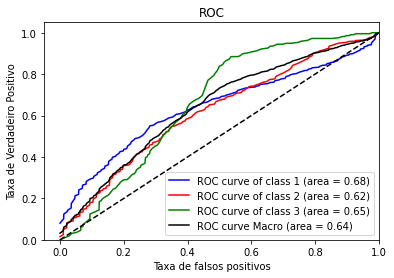

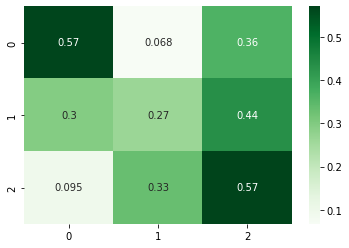

**********************0**********************
[3.807947176588889e-09] -> accuracy:0.6 -> F1-Macro:0.5777220230983672recall score-macro:0.6316765873015874
**********************1**********************
[3.807947176588889e-09] -> accuracy:0.5625 -> F1-Macro:0.5206594418486441recall score-macro:0.5669047619047619
**********************2**********************
[3.807947176588889e-09] -> accuracy:0.5625 -> F1-Macro:0.5428504847129009recall score-macro:0.6319191919191919
**********************3**********************
[3.807947176588889e-09] -> accuracy:0.60625 -> F1-Macro:0.5648201902918885recall score-macro:0.6300625300625301
**********************4**********************
[3.807947176588889e-09] -> accuracy:0.55 -> F1-Macro:0.5120587508945941recall score-macro:0.5801213144963145
**********************5**********************
[3.807947176588889e-09] -> accuracy:0.54375 -> F1-Macro:0.49311649311649325recall score-macro:0.5145500614250614
**********************6**********************
[3.80794717658

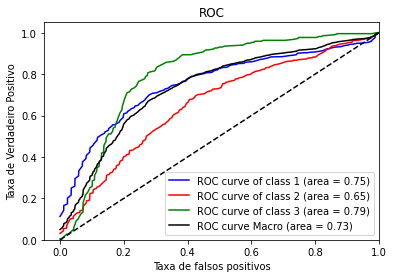

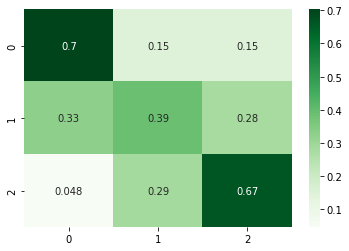

In [ ]:
for Sampler in Sampler_list:
  #Definições de listas para gurdar os valores obtidos em cada iteração 
  #Lista para as pontuações atingidas para cada iteração
  Score_list = []
  #Lista para as pontuações f1-Maxro atingidas para cada iteração
  F1_macro   = []
  #Lista para as pontuações recall_score atingidas para cada iteração
  recall_score_macro = []
  #Lista para as matrizes de confusão atingidas em cada iteração
  cm_list    = []
  #FRP, TPR, ROC_AUC da classe 1
  FRP_0      = []
  TPR_0      = []
  ROC_auc_0  = []
  #FRP, TPR, ROC_AUC da classe 2
  FRP_1      = []
  TPR_1      = []
  ROC_auc_1  = []
  #FRP, TPR, ROC_AUC da classe 3
  FRP_2      = []
  TPR_2      = []
  ROC_auc_2  = []

  #Importancia dos hiperparametros
  h_0 = []
  #Iniciando iterações
  for i in range(10):
          #Chamada de cada fold 
          Train_test_Kfold(i)
          scaler = MinMaxScaler(feature_range=(0, 1)) 
          Xtrain = scaler.fit_transform(Xtrain) 
          Xtest = scaler.transform(Xtest)
          Best = 0.0
          reset_seeds()
          def objective(trial):         
            #Busca de hiperparametros utilizando o Optruna como otimizador
            var_smoothing = trial.suggest_float("var_smoothing", 1e-10, 1e-08)

            #Modelo Utilizado -> KNN
            model = GaussianNB(var_smoothing=var_smoothing)

            #Variaveis globais
            global Best
            global Model
            global Lista
            if Sampler == "SMOTENearMiss":
              oversample = SMOTE(random_state = 9,sampling_strategy={2:480})
              X_res, y_res = oversample.fit_resample(Xtrain, ytrain)
              undersample=NearMiss(sampling_strategy={0:480, 1:480})
              X_res, y_res = undersample.fit_resample(X_res, y_res) 
              steps = [('over', oversample), ('under', undersample), ('m', model)]
            elif Sampler == SMOTE(random_state = 9):
              steps = [('over', Sampler), ('model', model)]
              X_res, y_res = Sampler.fit_resample(Xtrain, ytrain)
            else:
              steps = [('under', Sampler), ('model', model)]
              X_res, y_res = Sampler.fit_resample(Xtrain, ytrain)
            pipeline = Pipeline(steps=steps)
            #Inicializando Kfold-CrossValidation. (Utilizando 9/10 do conjunto de dados)
            kfold = StratifiedKFold(n_splits=10)
            score = cross_val_score(pipeline,Xtrain, ytrain, scoring='accuracy', cv=kfold)
            #Pontuação media Obtida
            Score = score.mean()

            #Salvando a melhor pontuação da iteração e aplicando o fit no modelo
            if Score > Best:
              Best = Score
              model.fit(X_res, y_res)
              Model = model
              Lista = [var_smoothing]


            return Score

          #Chamada do Optuna 
          sampler = TPESampler(seed=42) 
          study = optuna.create_study(direction="maximize", sampler=sampler)
          #Definição do numero de iterações -> 100
          study.optimize(objective, n_trials=100)

          #Ativação do modelo  para os dados de teste (1/10)
          ypred = Model.predict(Xtest)
          #Obtenção da Acurácia, F1-Score Macro e Matriz de confusão
          Acc = accuracy_score(ytest, ypred)
          F1 = f1_score(ytest, ypred, average='macro')
          rs = recall_score(ytest, ypred, average='macro')
          cm = confusion_matrix(ytest, ypred, normalize="true")
          #Append dos resultados obtidos na iteração
          Score_list.append(Acc)
          F1_macro.append(F1)
          recall_score_macro.append(rs)
          cm_list.append(cm)

          #Obtenção dos dados para curva ROC -> https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
          y_score = Model.predict_proba(Xtest)
          y_test = label_binarize(ytest, classes=[0,1,2])
          fpr = dict()
          tpr = dict()
          roc_auc = dict()
          for j in range(3):
            fpr[j], tpr[j], _ = roc_curve(y_test[:, j], y_score[:, j])
            roc_auc[j] = auc(fpr[j], tpr[j])
          FRP_0.append(fpr[0])
          TPR_0.append(tpr[0])
          ROC_auc_0.append(roc_auc[0])
          FRP_1.append(fpr[1])
          TPR_1.append(tpr[1])
          ROC_auc_1.append(roc_auc[1])
          FRP_2.append(fpr[2])
          TPR_2.append(tpr[2])
          ROC_auc_2.append(roc_auc[2])

          print("**********************"+str(i)+"**********************")
          print(str(Lista)+ " -> accuracy:"+str(Acc)+ " -> F1-Macro:"+ str(F1)+ "recall score-macro:"+ str(rs))

  #Criação da matriz de confusão media
  cm_sum = cm_list[0]
  for i in range(9):
    cm_sum = cm_list[i+1]+cm_sum
  cm_mean= cm_sum/10

  #Criação da curva ROC media
  all_fpr_0 =np.unique(np.concatenate([FRP_0[i] for i in range(10)]))

  mean_tpr_0 = np.zeros_like(all_fpr_0)
  for i in range(10):
      mean_tpr_0 += np.interp(all_fpr_0,FRP_0[i], TPR_0[i])
  mean_tpr_0 /= 10

  all_fpr_1 =np.unique(np.concatenate([FRP_1[i] for i in range(10)]))

  mean_tpr_1 = np.zeros_like(all_fpr_1)
  for i in range(10):
      mean_tpr_1 += np.interp(all_fpr_1,FRP_1[i], TPR_1[i])
  mean_tpr_1 /= 10


  all_fpr_2 =np.unique(np.concatenate([FRP_2[i] for i in range(10)]))

  mean_tpr_2 = np.zeros_like(all_fpr_2)
  for i in range(10):
      mean_tpr_2 += np.interp(all_fpr_2,FRP_2[i], TPR_2[i])
  mean_tpr_2 /= 10

  FRP = [all_fpr_0,all_fpr_1,all_fpr_2]
  TPR = [mean_tpr_0,mean_tpr_1,mean_tpr_2]

  all_fpr =np.unique(np.concatenate([FRP[i] for i in range(3)]))

  mean_tpr = np.zeros_like(all_fpr)
  for i in range(3):
      mean_tpr += np.interp(all_fpr,FRP[i], TPR[i])
  mean_tpr /= 3

  #Pontuações e desvio padrão
  print("Acuracia: %.2f%% (%.2f%%)" % (np.array(Score_list).mean()*100,np.array(Score_list).std()*100))
  print("F1-Score Macro: %.2f%% (%.2f%%)" % (np.array(F1_macro).mean()*100, np.array(F1_macro).std()*100))
  print("recall score macro: %.2f%% (%.2f%%)" % (np.array(recall_score_macro).mean()*100, np.array(recall_score_macro).std()*100))

  #Plots Finais
  roc_auc[3] = (auc(all_fpr, mean_tpr))
  colors = cycle(['blue', 'red', 'green'])
  a= [all_fpr_0,all_fpr_1,all_fpr_2, all_fpr]
  b = [mean_tpr_0,mean_tpr_1,mean_tpr_2, mean_tpr]
  for i, color in zip(range(3), colors):
      plt.plot(a[i], b[i], color=color,
              label='ROC curve of class {0} (area = {1:0.2f})'
              ''.format(i+1, roc_auc[i]))

  plt.plot(a[3], b[3], color="black",
              label='ROC curve Macro (area = {1:0.2f})'
              ''.format(1, roc_auc[3]))

  plt.plot([0, 1], [0, 1], 'k--')
  plt.xlim([-0.05, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('Taxa de falsos positivos')
  plt.ylabel('Taxa de Verdadeiro Positivo')
  plt.title('ROC')
  plt.legend(loc="lower right")
  plt.show()
  sns.heatmap(cm, annot=True, cmap="Greens")
  plt.show()

#***MLP (Multilayer perceptron)***

**********************0**********************
[55, 96, 26, 'adam', 0.0009113289155070948] -> accuracy:0.6125 -> F1-Macro:0.5842424242424243recall score-macro:0.6382738095238095
**********************1**********************
[80, 90, 30, 'adam', 0.000990850820015152] -> accuracy:0.6125 -> F1-Macro:0.591403496064513recall score-macro:0.6405654761904761
**********************2**********************
[54, 77, 23, 'adam', 0.0009314334687035898] -> accuracy:0.6 -> F1-Macro:0.5892199947825737recall score-macro:0.6414045214045214
**********************3**********************
[83, 62, 28, 'adam', 0.0009110331177584693] -> accuracy:0.65625 -> F1-Macro:0.6113389845957524recall score-macro:0.6887253487253487
**********************4**********************
[95, 62, 28, 'adam', 0.0008313366123856315] -> accuracy:0.56875 -> F1-Macro:0.5670178799489145recall score-macro:0.6198556511056511
**********************5**********************
[87, 93, 30, 'adam', 0.0006763850726289619] -> accuracy:0.56875 -> F1-Ma

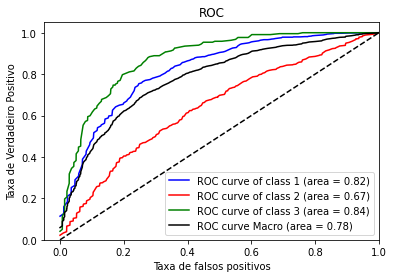

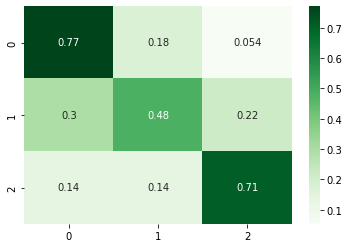

**********************0**********************
[89, 70, 30, 'adam', 0.0009721786433533176] -> accuracy:0.5875 -> F1-Macro:0.5546406024369577recall score-macro:0.6387698412698413
**********************1**********************
[97, 74, 29, 'adam', 0.0009792147177300015] -> accuracy:0.5875 -> F1-Macro:0.5252809788021056recall score-macro:0.6227579365079364
**********************2**********************
[88, 85, 28, 'adam', 0.0009815183285283734] -> accuracy:0.58125 -> F1-Macro:0.5377066187839792recall score-macro:0.6500336700336701
**********************3**********************
[100, 96, 29, 'adam', 0.0008356044252456367] -> accuracy:0.6 -> F1-Macro:0.5485275731509621recall score-macro:0.623078403078403
**********************4**********************
[96, 86, 28, 'adam', 0.0009981129619019606] -> accuracy:0.5375 -> F1-Macro:0.48705491065605844recall score-macro:0.5668893325143326
**********************5**********************
[67, 99, 30, 'adam', 0.0009810617420628177] -> accuracy:0.51875 -> F1-

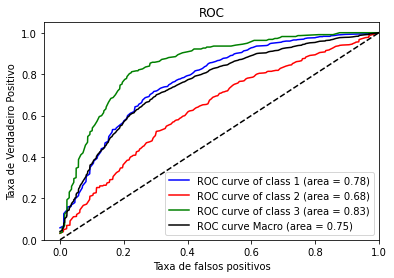

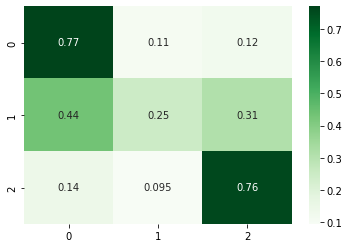

**********************0**********************
[79, 86, 27, 'adam', 0.0008426483953957131] -> accuracy:0.5625 -> F1-Macro:0.5360275689223057recall score-macro:0.5775694444444444
**********************1**********************
[99, 98, 22, 'adam', 0.0009382269727439591] -> accuracy:0.625 -> F1-Macro:0.583867815038788recall score-macro:0.6349702380952381
**********************2**********************
[61, 50, 29, 'adam', 0.0007196508834463047] -> accuracy:0.59375 -> F1-Macro:0.5720412652232271recall score-macro:0.640894660894661
**********************3**********************
[55, 92, 28, 'adam', 0.0009689322592004513] -> accuracy:0.64375 -> F1-Macro:0.5959595114139199recall score-macro:0.6575757575757576
**********************4**********************
[64, 92, 27, 'adam', 0.0008992762227781644] -> accuracy:0.575 -> F1-Macro:0.569752794835459recall score-macro:0.6144169737919738
**********************5**********************
[75, 88, 21, 'adam', 0.0008743860215091414] -> accuracy:0.55625 -> F1-Ma

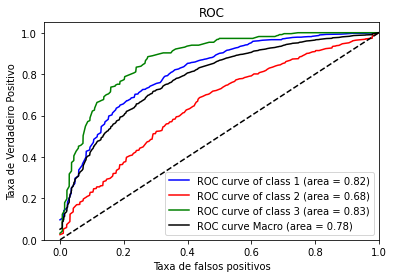

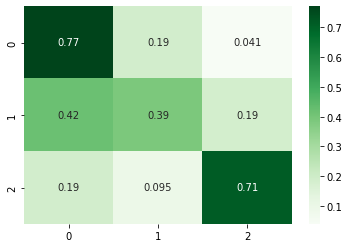

In [ ]:
for Sampler in Sampler_list:
  #Definições de listas para gurdar os valores obtidos em cada iteração 
  #Lista para as pontuações atingidas para cada iteração
  Score_list = []
  #Lista para as pontuações f1-Maxro atingidas para cada iteração
  F1_macro   = []
  #Lista para as pontuações recall_score atingidas para cada iteração
  recall_score_macro = []
  #Lista para as matrizes de confusão atingidas em cada iteração
  cm_list    = []
  #FRP, TPR, ROC_AUC da classe 1
  FRP_0      = []
  TPR_0      = []
  ROC_auc_0  = []
  #FRP, TPR, ROC_AUC da classe 2
  FRP_1      = []
  TPR_1      = []
  ROC_auc_1  = []
  #FRP, TPR, ROC_AUC da classe 3
  FRP_2      = []
  TPR_2      = []
  ROC_auc_2  = []

  #Importancia dos hiperparametros
  h_0 = []
  h_1 = []
  h_2 = []
  h_3 = []
  h_4 = []

  #Iniciando iterações
  for i in range(10):
          #Chamada de cada fold 
          Train_test_Kfold(i)
          scaler = MinMaxScaler(feature_range=(0, 1)) 
          Xtrain = scaler.fit_transform(Xtrain) 
          Xtest = scaler.transform(Xtest)
          Best = 0.0
          reset_seeds()
          def objective(trial):         
            #Busca de hiperparametros utilizando o Optruna como otimizador
            neurons1    = trial.suggest_int("neurons1", 50, 100)
            neurons2    = trial.suggest_int("neurons2", 50, 100)
            max_iter    = trial.suggest_int("max_iter", 10, 30)
            solver      = trial.suggest_categorical("solver", ['adam', 'sgd'])
            learning_rate_init   = trial.suggest_float("learning_rate_init", 0.0001, 0.001)


            #Modelo Utilizado -> MLP
            model = MLPClassifier(hidden_layer_sizes=(neurons1,neurons2), max_iter=max_iter,solver=solver, verbose=False,  learning_rate_init=learning_rate_init)

            #Variaveis globais
            global Best
            global Model
            global Lista
            if Sampler == "SMOTENearMiss":
              oversample = SMOTE(random_state = 9,sampling_strategy={2:480})
              X_res, y_res = oversample.fit_resample(Xtrain, ytrain)
              undersample=NearMiss(sampling_strategy={0:480, 1:480})
              X_res, y_res = undersample.fit_resample(X_res, y_res) 
              steps = [('over', oversample), ('under', undersample), ('m', model)]
            elif Sampler == SMOTE(random_state = 9):
              steps = [('over', Sampler), ('model', model)]
              X_res, y_res = Sampler.fit_resample(Xtrain, ytrain)
            else:
              steps = [('under', Sampler), ('model', model)]
              X_res, y_res = Sampler.fit_resample(Xtrain, ytrain)
            pipeline = Pipeline(steps=steps)
            #Inicializando Kfold-CrossValidation. (Utilizando 9/10 do conjunto de dados)
            kfold = StratifiedKFold(n_splits=10)
            score = cross_val_score(pipeline,Xtrain, ytrain, scoring='accuracy', cv=kfold)
            #Pontuação media Obtida
            Score = score.mean()
            #Salvando a melhor pontuação da iteração e aplicando o fit no modelo
            if Score > Best:
              Best = Score
              model.fit(X_res, y_res)
              Model = model
              Lista = [neurons1,neurons2,max_iter,solver,learning_rate_init]


            return Score

          #Chamada do Optuna 
          sampler = TPESampler(seed=42) 
          study = optuna.create_study(direction="maximize", sampler=sampler)
          #Definição do numero de iterações -> 100
          study.optimize(objective, n_trials=100)

          Importance = optuna.importance.get_param_importances(study)

          h_0.append(Importance["neurons1"])
          h_1.append(Importance["neurons2"])
          h_2.append(Importance["max_iter"])
          h_3.append(Importance["solver"])
          h_4.append(Importance["learning_rate_init"])
          

          #Ativação do modelo  para os dados de teste (1/10)
          ypred = Model.predict(Xtest)
          #Obtenção da Acurácia, F1-Score Macro e Matriz de confusão
          Acc = accuracy_score(ytest, ypred)
          F1 = f1_score(ytest, ypred, average='macro')
          rs = recall_score(ytest, ypred, average='macro')
          cm = confusion_matrix(ytest, ypred, normalize="true")
          #Append dos resultados obtidos na iteração
          Score_list.append(Acc)
          F1_macro.append(F1)
          recall_score_macro.append(rs)
          cm_list.append(cm)

          #Obtenção dos dados para curva ROC -> https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
          y_score = Model.predict_proba(Xtest)
          y_test = label_binarize(ytest, classes=[0,1,2])
          fpr = dict()
          tpr = dict()
          roc_auc = dict()
          for j in range(3):
            fpr[j], tpr[j], _ = roc_curve(y_test[:, j], y_score[:, j])
            roc_auc[j] = auc(fpr[j], tpr[j])
          FRP_0.append(fpr[0])
          TPR_0.append(tpr[0])
          ROC_auc_0.append(roc_auc[0])
          FRP_1.append(fpr[1])
          TPR_1.append(tpr[1])
          ROC_auc_1.append(roc_auc[1])
          FRP_2.append(fpr[2])
          TPR_2.append(tpr[2])
          ROC_auc_2.append(roc_auc[2])

          print("**********************"+str(i)+"**********************")
          print(str(Lista)+ " -> accuracy:"+str(Acc)+ " -> F1-Macro:"+ str(F1)+ "recall score-macro:"+ str(rs))

  #Criação da matriz de confusão media
  cm_sum = cm_list[0]
  for i in range(9):
    cm_sum = cm_list[i+1]+cm_sum
  cm_mean= cm_sum/10

  #Criação da curva ROC media
  all_fpr_0 =np.unique(np.concatenate([FRP_0[i] for i in range(10)]))

  mean_tpr_0 = np.zeros_like(all_fpr_0)
  for i in range(10):
      mean_tpr_0 += np.interp(all_fpr_0,FRP_0[i], TPR_0[i])
  mean_tpr_0 /= 10

  all_fpr_1 =np.unique(np.concatenate([FRP_1[i] for i in range(10)]))

  mean_tpr_1 = np.zeros_like(all_fpr_1)
  for i in range(10):
      mean_tpr_1 += np.interp(all_fpr_1,FRP_1[i], TPR_1[i])
  mean_tpr_1 /= 10


  all_fpr_2 =np.unique(np.concatenate([FRP_2[i] for i in range(10)]))

  mean_tpr_2 = np.zeros_like(all_fpr_2)
  for i in range(10):
      mean_tpr_2 += np.interp(all_fpr_2,FRP_2[i], TPR_2[i])
  mean_tpr_2 /= 10

  FRP = [all_fpr_0,all_fpr_1,all_fpr_2]
  TPR = [mean_tpr_0,mean_tpr_1,mean_tpr_2]

  all_fpr =np.unique(np.concatenate([FRP[i] for i in range(3)]))

  mean_tpr = np.zeros_like(all_fpr)
  for i in range(3):
      mean_tpr += np.interp(all_fpr,FRP[i], TPR[i])
  mean_tpr /= 3
  #Pontuações e desvio padrão
  print("Acuracia: %.2f%% (%.2f%%)" % (np.array(Score_list).mean()*100,np.array(Score_list).std()*100))
  print("F1-Score Macro: %.2f%% (%.2f%%)" % (np.array(F1_macro).mean()*100, np.array(F1_macro).std()*100))
  print("recall score macro: %.2f%% (%.2f%%)" % (np.array(recall_score_macro).mean()*100, np.array(recall_score_macro).std()*100))
  print("neurons1: %.2f%%, neurons2: %.2f%%, max_iter: %.2f%%, solver: %.2f%%, learning_rate_init: %.2f%%" % (np.array(h_0).mean(), np.array(h_1).mean(), np.array(h_2).mean(),np.array(h_3).mean(),np.array(h_4).mean()))
  #Plots Finais
  roc_auc[3] = (auc(all_fpr, mean_tpr))
  colors = cycle(['blue', 'red', 'green'])
  a= [all_fpr_0,all_fpr_1,all_fpr_2, all_fpr]
  b = [mean_tpr_0,mean_tpr_1,mean_tpr_2, mean_tpr]
  for i, color in zip(range(3), colors):
      plt.plot(a[i], b[i], color=color,
              label='ROC curve of class {0} (area = {1:0.2f})'
              ''.format(i+1, roc_auc[i]))

  plt.plot(a[3], b[3], color="black",
              label='ROC curve Macro (area = {1:0.2f})'
              ''.format(1, roc_auc[3]))

  plt.plot([0, 1], [0, 1], 'k--')
  plt.xlim([-0.05, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('Taxa de falsos positivos')
  plt.ylabel('Taxa de Verdadeiro Positivo')
  plt.title('ROC')
  plt.legend(loc="lower right")
  plt.show()
  sns.heatmap(cm, annot=True, cmap="Greens")
  plt.show()

#***SVM (Support Vector Machines)***

**********************0**********************
[1, 'rbf', 7.896483961685482] -> accuracy:0.6375 -> F1-Macro:0.5989876947323756recall score-macro:0.614156746031746
**********************1**********************
[10, 'rbf', 1.4738074962621652] -> accuracy:0.64375 -> F1-Macro:0.6131952971729403recall score-macro:0.6521230158730159
**********************2**********************
[2, 'rbf', 6.5091812057153575] -> accuracy:0.6625 -> F1-Macro:0.6462750625907302recall score-macro:0.681067821067821
**********************3**********************
[7, 'rbf', 4.384082563321014] -> accuracy:0.75625 -> F1-Macro:0.7313430627144756recall score-macro:0.742106782106782
**********************4**********************
[4, 'rbf', 5.735553324382723] -> accuracy:0.66875 -> F1-Macro:0.667564197040984recall score-macro:0.6762643325143326
**********************5**********************
[7, 'rbf', 2.817719677768852] -> accuracy:0.6375 -> F1-Macro:0.6186546262136813recall score-macro:0.6345592751842751
********************

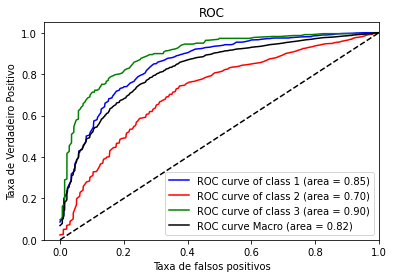

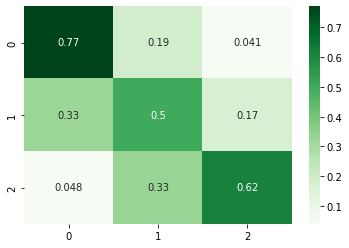

**********************0**********************
[4, 'linear', 1.6445845403801216] -> accuracy:0.575 -> F1-Macro:0.5280883367839889recall score-macro:0.6054960317460317
**********************1**********************
[6, 'linear', 3.604297058553235] -> accuracy:0.6 -> F1-Macro:0.5593831289483463recall score-macro:0.6468948412698413
**********************2**********************
[5, 'linear', 0.45579150224126175] -> accuracy:0.59375 -> F1-Macro:0.5450640862405568recall score-macro:0.6383549783549783
**********************3**********************
[4, 'linear', 1.6445845403801216] -> accuracy:0.61875 -> F1-Macro:0.5701065226017153recall score-macro:0.647965367965368
**********************4**********************
[9, 'linear', 8.555842294841383] -> accuracy:0.5125 -> F1-Macro:0.44227493799097223recall score-macro:0.5048756142506142
**********************5**********************
[9, 'linear', 8.555842294841383] -> accuracy:0.575 -> F1-Macro:0.5366248817407757recall score-macro:0.5803644553644554
***

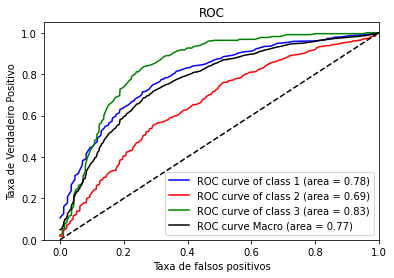

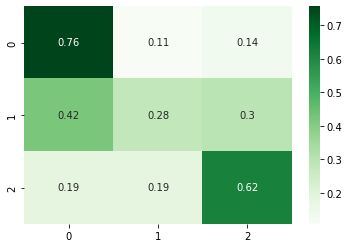

**********************0**********************
[6, 'rbf', 4.031552609423449] -> accuracy:0.65625 -> F1-Macro:0.6077164120642381recall score-macro:0.6267261904761904
**********************1**********************
[2, 'rbf', 7.911347132430812] -> accuracy:0.675 -> F1-Macro:0.6317139650472984recall score-macro:0.6644444444444444
**********************2**********************
[3, 'rbf', 7.5416720782381566] -> accuracy:0.68125 -> F1-Macro:0.6898849770275022recall score-macro:0.6977873977873977
**********************3**********************
[3, 'rbf', 5.604453562885034] -> accuracy:0.71875 -> F1-Macro:0.6882134250279197recall score-macro:0.7202212602212601
**********************4**********************
[5, 'rbf', 7.472142904562284] -> accuracy:0.63125 -> F1-Macro:0.6313418364592064recall score-macro:0.6457181613431614
**********************5**********************
[2, 'rbf', 4.685562103848045] -> accuracy:0.65 -> F1-Macro:0.6333333333333333recall score-macro:0.6521038083538083
********************

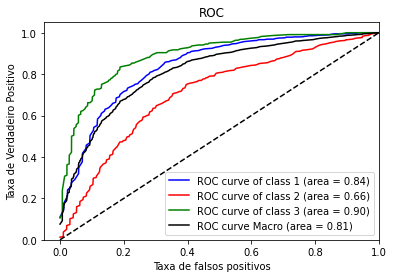

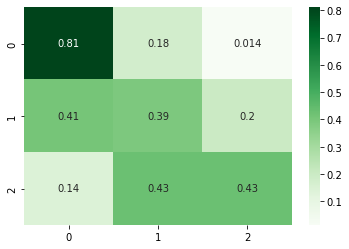

In [ ]:
for Sampler in Sampler_list:
  #Definições de listas para gurdar os valores obtidos em cada iteração 
  #Lista para as pontuações atingidas para cada iteração
  Score_list = []
  #Lista para as pontuações f1-Maxro atingidas para cada iteração
  F1_macro   = []
  #Lista para as pontuações recall_score atingidas para cada iteração
  recall_score_macro = []
  #Lista para as matrizes de confusão atingidas em cada iteração
  cm_list    = []
  #FRP, TPR, ROC_AUC da classe 1
  FRP_0      = []
  TPR_0      = []
  ROC_auc_0  = []
  #FRP, TPR, ROC_AUC da classe 2
  FRP_1      = []
  TPR_1      = []
  ROC_auc_1  = []
  #FRP, TPR, ROC_AUC da classe 3
  FRP_2      = []
  TPR_2      = []
  ROC_auc_2  = []

  #Importancia dos hiperparametros
  h_0 = []
  h_1 = []
  h_2 = []


  #Iniciando iterações
  for i in range(10):
          #Chamada de cada fold 
          Train_test_Kfold(i)
          scaler = MinMaxScaler(feature_range=(0, 1)) 
          Xtrain = scaler.fit_transform(Xtrain) 
          Xtest = scaler.transform(Xtest)
          Best = 0.0
          reset_seeds()
          def objective(trial):         
            #Busca de hiperparametros utilizando o Optruna como otimizador
            C = trial.suggest_int("C", 1, 10)
            kernel     = trial.suggest_categorical("kernel", ['linear','rbf', 'sigmoid'])
            gamma   = trial.suggest_float("gamma", 0.1, 10)

            #Modelo Utilizado -> SVN
            model = SVC(C=C, kernel=kernel, gamma=gamma,  random_state=0, probability=True)

            #Variaveis globais
            global Best
            global Model
            global Lista
            if Sampler == "SMOTENearMiss":
              oversample = SMOTE(random_state = 9,sampling_strategy={2:480})
              X_res, y_res = oversample.fit_resample(Xtrain, ytrain)
              undersample=NearMiss(sampling_strategy={0:480, 1:480})
              X_res, y_res = undersample.fit_resample(X_res, y_res) 
              steps = [('over', oversample), ('under', undersample), ('m', model)]
            elif Sampler == SMOTE(random_state = 9):
              steps = [('over', Sampler), ('model', model)]
              X_res, y_res = Sampler.fit_resample(Xtrain, ytrain)
            else:
              steps = [('under', Sampler), ('model', model)]
              X_res, y_res = Sampler.fit_resample(Xtrain, ytrain)
            pipeline = Pipeline(steps=steps)
            #Inicializando Kfold-CrossValidation. (Utilizando 9/10 do conjunto de dados)
            kfold = StratifiedKFold(n_splits=10)
            score = cross_val_score(pipeline,Xtrain, ytrain, scoring='accuracy', cv=kfold)
            #Pontuação media Obtida
            Score = score.mean()

            #Salvando a melhor pontuação da iteração e aplicando o fit no modelo
            if Score > Best:
              Best = Score
              model.fit(X_res, y_res)
              Model = model
              Lista = [C, kernel, gamma]


            return Score

          #Chamada do Optuna 
          sampler = TPESampler(seed=42) 
          study = optuna.create_study(direction="maximize", sampler=sampler)
          #Definição do numero de iterações -> 100
          study.optimize(objective, n_trials=100)

          Importance = optuna.importance.get_param_importances(study)

          h_0.append(Importance["C"])
          h_1.append(Importance["kernel"])
          h_2.append(Importance["gamma"])

          

          #Ativação do modelo  para os dados de teste (1/10)
          ypred = Model.predict(Xtest)
          #Obtenção da Acurácia, F1-Score Macro e Matriz de confusão
          Acc = accuracy_score(ytest, ypred)
          F1 = f1_score(ytest, ypred, average='macro')
          rs = recall_score(ytest, ypred, average='macro')
          cm = confusion_matrix(ytest, ypred, normalize="true")
          #Append dos resultados obtidos na iteração
          Score_list.append(Acc)
          F1_macro.append(F1)
          recall_score_macro.append(rs)
          cm_list.append(cm)

          #Obtenção dos dados para curva ROC -> https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
          y_score = Model.predict_proba(Xtest)
          y_test = label_binarize(ytest, classes=[0,1,2])
          fpr = dict()
          tpr = dict()
          roc_auc = dict()
          for j in range(3):
            fpr[j], tpr[j], _ = roc_curve(y_test[:, j], y_score[:, j])
            roc_auc[j] = auc(fpr[j], tpr[j])
          FRP_0.append(fpr[0])
          TPR_0.append(tpr[0])
          ROC_auc_0.append(roc_auc[0])
          FRP_1.append(fpr[1])
          TPR_1.append(tpr[1])
          ROC_auc_1.append(roc_auc[1])
          FRP_2.append(fpr[2])
          TPR_2.append(tpr[2])
          ROC_auc_2.append(roc_auc[2])

          print("**********************"+str(i)+"**********************")
          print(str(Lista)+ " -> accuracy:"+str(Acc)+ " -> F1-Macro:"+ str(F1)+ "recall score-macro:"+ str(rs))

  #Criação da matriz de confusão media
  cm_sum = cm_list[0]
  for i in range(9):
    cm_sum = cm_list[i+1]+cm_sum
  cm_mean= cm_sum/10

  #Criação da curva ROC media
  all_fpr_0 =np.unique(np.concatenate([FRP_0[i] for i in range(10)]))

  mean_tpr_0 = np.zeros_like(all_fpr_0)
  for i in range(10):
      mean_tpr_0 += np.interp(all_fpr_0,FRP_0[i], TPR_0[i])
  mean_tpr_0 /= 10

  all_fpr_1 =np.unique(np.concatenate([FRP_1[i] for i in range(10)]))

  mean_tpr_1 = np.zeros_like(all_fpr_1)
  for i in range(10):
      mean_tpr_1 += np.interp(all_fpr_1,FRP_1[i], TPR_1[i])
  mean_tpr_1 /= 10


  all_fpr_2 =np.unique(np.concatenate([FRP_2[i] for i in range(10)]))

  mean_tpr_2 = np.zeros_like(all_fpr_2)
  for i in range(10):
      mean_tpr_2 += np.interp(all_fpr_2,FRP_2[i], TPR_2[i])
  mean_tpr_2 /= 10

  FRP = [all_fpr_0,all_fpr_1,all_fpr_2]
  TPR = [mean_tpr_0,mean_tpr_1,mean_tpr_2]

  all_fpr =np.unique(np.concatenate([FRP[i] for i in range(3)]))

  mean_tpr = np.zeros_like(all_fpr)
  for i in range(3):
      mean_tpr += np.interp(all_fpr,FRP[i], TPR[i])
  mean_tpr /= 3

  #Pontuações e desvio padrão
  print("Acuracia: %.2f%% (%.2f%%)" % (np.array(Score_list).mean()*100,np.array(Score_list).std()*100))
  print("F1-Score Macro: %.2f%% (%.2f%%)" % (np.array(F1_macro).mean()*100, np.array(F1_macro).std()*100))
  print("recall score macro: %.2f%% (%.2f%%)" % (np.array(recall_score_macro).mean()*100, np.array(recall_score_macro).std()*100))
  print("C: %.2f%%, kernel: %.2f%%, gamma: %.2f%%" % (np.array(h_0).mean(), np.array(h_1).mean(), np.array(h_2).mean()))
  #Plots Finais
  roc_auc[3] = (auc(all_fpr, mean_tpr))
  colors = cycle(['blue', 'red', 'green'])
  a= [all_fpr_0,all_fpr_1,all_fpr_2, all_fpr]
  b = [mean_tpr_0,mean_tpr_1,mean_tpr_2, mean_tpr]
  for i, color in zip(range(3), colors):
      plt.plot(a[i], b[i], color=color,
              label='ROC curve of class {0} (area = {1:0.2f})'
              ''.format(i+1, roc_auc[i]))

  plt.plot(a[3], b[3], color="black",
              label='ROC curve Macro (area = {1:0.2f})'
              ''.format(1, roc_auc[3]))

  plt.plot([0, 1], [0, 1], 'k--')
  plt.xlim([-0.05, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('Taxa de falsos positivos')
  plt.ylabel('Taxa de Verdadeiro Positivo')
  plt.title('ROC')
  plt.legend(loc="lower right")
  plt.show()
  sns.heatmap(cm, annot=True, cmap="Greens")
  plt.show()